This notebook contains code for the first FFNN (before optimization) and code for all LSTM models 

# FFNN

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.regularizers import l2


In [13]:
def read_table(path):
    """Reads table and drops irrelevant rows and columns.
    Returns an analysis ready DataFrame"""
    df = pd.read_table('EMG/'+path)
    df = df[df['class']!=0]
    df = df[df['class'] != 7]
    df.drop(columns=['time'], inplace=True)

    # Map the classes so they range from 0-6 for cross entropy loss to work
    mapping = {1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6} # get rid of 7 later
    df['class'] = df['class'].map(mapping)

    df.reset_index(drop=True,inplace=True)
    return df


def scaler(df):
    """Normalizes the data, returns a DataFrame with the new scaled numbers"""
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled, columns=df.columns)
    return df_scaled

In [14]:
# Creating full dataset by combining all the subjects' data
df = pd.concat([read_table('1/1_1.txt'), read_table('1/2_1.txt')])
for n in range(2,37):
    path1 = f'{n}/1_{n}.txt'
    df = pd.concat([df, read_table(path1)])
    path2 = f'{n}/2_{n}.txt'
    df = pd.concat([df, read_table(path2)])

# We found one row with NaN as a class value so we just dropped it.
df = df.dropna()

df.reset_index(drop=True,inplace=True)

df.head()

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,0.0
1,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,0.0
2,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,0.0
3,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,0.0
4,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,0.0


In [15]:
# Creating train/test split and scaling input data
x = df.drop(columns='class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=3)
X_train = scaler(X_train)
X_test = scaler(X_test)

In [20]:
# What our scaled input data looks like
X_train.head()

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
0,-0.379317,-0.586147,-0.944383,-0.418188,-0.161108,-0.033096,-0.114519,-0.198136
1,-0.009885,-0.075221,-0.002796,-0.002283,-0.097792,-0.033096,-0.057836,0.001964
2,-0.590421,-1.243051,-3.262134,-2.081805,-1.142495,-0.033096,-0.964764,-0.748410
3,-1.857043,5.763924,1.083650,0.678287,2.561451,2.977124,1.926071,0.552237
4,-1.593163,-2.629848,-0.582234,-0.115712,0.028838,-0.153505,-0.057836,1.502711


In [23]:
# FFNN model attempt 1 (with last gesture removed)
model = Sequential()
model.add(Dense(10, input_dim=8, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(6,activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=30)

Epoch 1/20


2024-05-07 14:21:07.500746: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


39975/39975 [==============================] - 21s 513us/step - loss: 1.0451 - accuracy: 0.5846
Epoch 2/20
39975/39975 [==============================] - 20s 512us/step - loss: 0.9863 - accuracy: 0.6089
Epoch 3/20
39975/39975 [==============================] - 21s 518us/step - loss: 0.9800 - accuracy: 0.6104
Epoch 4/20
39975/39975 [==============================] - 21s 535us/step - loss: 0.9767 - accuracy: 0.6112
Epoch 5/20
39975/39975 [==============================] - 21s 519us/step - loss: 0.9733 - accuracy: 0.6119
Epoch 6/20
39975/39975 [==============================] - 20s 513us/step - loss: 0.9713 - accuracy: 0.6127
Epoch 7/20
39975/39975 [==============================] - 20s 506us/step - loss: 0.9705 - accuracy: 0.6130
Epoch 8/20
39975/39975 [==============================] - 24s 607us/step - loss: 0.9701 - accuracy: 0.6133
Epoch 9/20
39975/39975 [==============================] - 20s 501us/step - loss: 0.9698 - accuracy: 0.6134
Epoch 10/20
39975/39975 [=======================

In [28]:
# Look at test accuracy
loss, accuracy = model.evaluate(X_test,y_test)
print(f'Testing accuracy: {accuracy}')

# About the same as training, so hopefully no overfitting

9370/9370 [==============================] - 4s 421us/step - loss: 0.9674 - accuracy: 0.6144
Testing accuracy: 0.6143770813941956


9370/9370 [==============================] - 3s 355us/step


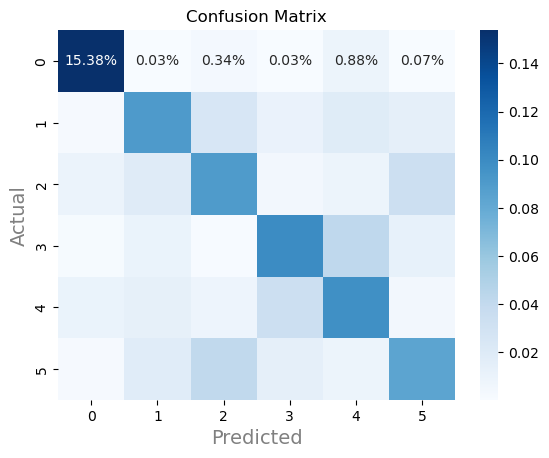

In [26]:
# TODO: AKSHAYA add confusion matrix (and  maybe small analysis) here, mine doesn't properly show numbers
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.2%', xticklabels=[f'0', '1', '2', '3', '4', '5'], 
            yticklabels=[f'0', '1', '2', '3', '4', '5'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize=14, color='grey')
plt.ylabel('Actual', fontsize=14, color='grey')
plt.show()

# LSTM

In [32]:
# There are two sets of readings for each gesture in each dataset. 
# Here we make a function to collect readings for each gesture over a 1 second window of time
def collect_readings(df):
    """
    Collects the readings for each gesture in given df over a 1 second window.
    Returns two arrays, one containing the readings of shape (12, 1000, 8)
    and another of shape (12,) containing the respective gesture class.
    """
    readings = np.zeros((12,1000,8))
    gestures = np.zeros((12))
    index = 0
    for i in range(6):
        first = df[df['class']==i].iloc[:1000]
        second = df[df['class']==i].iloc[-1000:]
        readings1 = first.drop(columns='class').values
        readings2 = second.drop(columns='class').values
        readings[index] = readings1
        readings[index+1] = readings2
        gestures[index] = i
        gestures[index+1] = i
        index += 2

    return readings,gestures

# Here is a similar function to the one above, but collects readings over 0.5 second window
def collect_readings2(df):
    """
    Collects the readings for each gesture in given df over a 0.5 second window.
    Returns two arrays, one containing the readings of shape (24, 500, 8)
    and another of shape (24,) containing the respective gesture class.
    """
    readings = np.zeros((24,500,8))
    gestures = np.zeros((24))
    index = 0
    for i in range(6):
        first = df[df['class']==i].iloc[:500].drop(columns='class').values
        sec = df[df['class']==i].iloc[500:1000].drop(columns='class').values
        third = df[df['class']==i].iloc[-500:].drop(columns='class').values
        fourth = df[df['class']==i].iloc[-1000:-500].drop(columns='class').values
        readings[index] = first
        readings[index+1] = sec
        readings[index+2] = third
        readings[index+3] = fourth
        gestures[index:index+4] = i
        index += 4

    return readings,gestures

In [37]:
# Code to create input and output arrays for LSTM (1 second window)
df1 = read_table('1/1_1.txt')
df2 = read_table('1/2_1.txt')
x1, y1 = collect_readings(df1)
x2, y2 = collect_readings(df2)
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
for n in range(2,37):
    path1 = f'{n}/1_{n}.txt'
    df1 = read_table(path1)
    readings1, gestures1 = collect_readings(df1)
    x = np.concatenate((x, readings1))
    y = np.concatenate((y, gestures1))
    
    path2 = f'{n}/2_{n}.txt'
    df2 = read_table(path2)
    readings2, gestures2 = collect_readings(df2)
    x = np.concatenate((x, readings2))
    y = np.concatenate((y, gestures2))

In [39]:
# Making train/test split and normalizing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=3)

scaler = StandardScaler()
reshaped = X_train.reshape(-1, X_train.shape[-1])
normalized = scaler.fit_transform(reshaped)
X_train = normalized.reshape(X_train.shape)

scaler = StandardScaler()
reshaped = X_test.reshape(-1, X_test.shape[-1])
normalized = scaler.fit_transform(reshaped)
X_test = normalized.reshape(X_test.shape)

In [40]:
# LSTM model attempt 1 
model = Sequential()
model.add(LSTM(10, input_shape=(1000, 8), input_dim=8, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=30)

# Performance looks pretty bad here

Epoch 1/20
24/24 [==============================] - 4s 153ms/step - loss: 1.8257 - accuracy: 0.1592
Epoch 2/20
24/24 [==============================] - 4s 154ms/step - loss: 1.7631 - accuracy: 0.1809
Epoch 3/20
24/24 [==============================] - 4s 153ms/step - loss: 1.7301 - accuracy: 0.1910
Epoch 4/20
24/24 [==============================] - 4s 154ms/step - loss: 1.6990 - accuracy: 0.2069
Epoch 5/20
24/24 [==============================] - 4s 158ms/step - loss: 6.7351 - accuracy: 0.2142
Epoch 6/20
24/24 [==============================] - 4s 159ms/step - loss: 4.5117 - accuracy: 0.2735
Epoch 7/20
24/24 [==============================] - 4s 156ms/step - loss: 2.2627 - accuracy: 0.3039
Epoch 8/20
24/24 [==============================] - 4s 157ms/step - loss: 2.5985 - accuracy: 0.2692
Epoch 9/20
24/24 [==============================] - 4s 157ms/step - loss: 1.7756 - accuracy: 0.2981
Epoch 10/20
24/24 [==============================] - 4s 158ms/step - loss: 1.6946 - accuracy: 0.3184

In [41]:
# Model attempt 2: we changed the activation function to tanh
model = Sequential()
model.add(LSTM(10, input_shape=(1000, 8), input_dim=8, activation='tanh'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=30)

# Looking much better with tanh

Epoch 1/20


2024-05-07 15:23:05.600826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-07 15:23:05.602011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-07 15:23:05.602881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 5s 162ms/step - loss: 1.8235 - accuracy: 0.1722
Epoch 2/20
24/24 [==============================] - 4s 162ms/step - loss: 1.8036 - accuracy: 0.2026
Epoch 3/20
24/24 [==============================] - 4s 162ms/step - loss: 1.7882 - accuracy: 0.2287
Epoch 4/20
24/24 [==============================] - 4s 161ms/step - loss: 1.7734 - accuracy: 0.2518
Epoch 5/20
24/24 [==============================] - 4s 162ms/step - loss: 1.7593 - accuracy: 0.2865
Epoch 6/20
24/24 [==============================] - 4s 161ms/step - loss: 1.7448 - accuracy: 0.3010
Epoch 7/20
24/24 [==============================] - 4s 160ms/step - loss: 1.7293 - accuracy: 0.3256
Epoch 8/20
24/24 [==============================] - 4s 162ms/step - loss: 1.7128 - accuracy: 0.3372
Epoch 9/20
24/24 [==============================] - 4s 162ms/step - loss: 1.6925 - accuracy: 0.3343
Epoch 10/20
24/24 [==============================] - 4s 162ms/step - loss: 1.6600 - accuracy: 0.3415
Epoch 11/2

In [42]:
# Look at test accuracy
loss, accuracy = model.evaluate(X_test,y_test)
print(f'Testing accuracy: {accuracy}')

# Testing accuracy not too far off from training
# Accuracy is still pretty low overall but tanh looks like it is going to be a better activation function

2024-05-07 15:24:37.821238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-07 15:24:37.822261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-07 15:24:37.822984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 30ms/step - loss: 1.4420 - accuracy: 0.4220
Testing accuracy: 0.4219653308391571


In [49]:
# Adding more layers and nodes to increase accuracy as well as l2 regularization to address overfitting concerns
model = Sequential()
model.add(LSTM(50, input_shape=(1000, 8), input_dim=8, activation='tanh',kernel_regularizer=l2(0.01),return_sequences=True))
model.add(LSTM(20, input_shape=(1000, 8), input_dim=8, activation='tanh',kernel_regularizer=l2(0.01)))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=30)

2024-05-05 16:55:20.000277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 16:55:20.001462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 16:55:20.002186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-05 16:55:20.688293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 16:55:20.692768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 16:55:20.695057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 15s 528ms/step - loss: 2.4695 - accuracy: 0.2142
Epoch 2/20
24/24 [==============================] - 14s 569ms/step - loss: 2.2246 - accuracy: 0.3922
Epoch 3/20
24/24 [==============================] - 14s 582ms/step - loss: 1.9275 - accuracy: 0.4038
Epoch 4/20
24/24 [==============================] - 13s 534ms/step - loss: 1.6933 - accuracy: 0.4703
Epoch 5/20
24/24 [==============================] - 12s 520ms/step - loss: 1.5112 - accuracy: 0.4834
Epoch 6/20
24/24 [==============================] - 13s 525ms/step - loss: 1.3476 - accuracy: 0.5384
Epoch 7/20
24/24 [==============================] - 15s 604ms/step - loss: 1.2482 - accuracy: 0.5441
Epoch 8/20
24/24 [==============================] - 13s 532ms/step - loss: 1.1794 - accuracy: 0.6281
Epoch 9/20
24/24 [==============================] - 12s 519ms/step - loss: 1.1519 - accuracy: 0.6194
Epoch 10/20
24/24 [==============================] - 13s 536ms/step - loss: 1.0425 - accuracy: 0.6165


In [50]:
model.evaluate(X_test,y_test)

# Accuracy is looking better with the extra layer, testing still a bit lower by 0.05 but not bad at all!

2024-05-05 17:00:01.188303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 17:00:01.189676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 17:00:01.190941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 99ms/step - loss: 1.2598 - accuracy: 0.5607


[1.2598174810409546, 0.560693621635437]

In [51]:
# Adding a dropout layer to see if we can make overfitting better
model = Sequential()
model.add(LSTM(50, input_shape=(1000, 8), input_dim=8, activation='tanh',kernel_regularizer=l2(0.01),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20, input_shape=(1000, 8), input_dim=8, activation='tanh',kernel_regularizer=l2(0.01)))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=30)

2024-05-05 17:01:09.098058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 17:01:09.099373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 17:01:09.100531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-05 17:01:09.896718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 17:01:09.898619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 17:01:09.899824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 18s 623ms/step - loss: 2.4877 - accuracy: 0.2055
Epoch 2/20
24/24 [==============================] - 13s 530ms/step - loss: 2.2594 - accuracy: 0.3386
Epoch 3/20
24/24 [==============================] - 13s 543ms/step - loss: 2.0441 - accuracy: 0.4226
Epoch 4/20
24/24 [==============================] - 13s 548ms/step - loss: 1.8209 - accuracy: 0.4428
Epoch 5/20
24/24 [==============================] - 13s 561ms/step - loss: 1.6303 - accuracy: 0.4906
Epoch 6/20
24/24 [==============================] - 13s 552ms/step - loss: 1.4685 - accuracy: 0.5586
Epoch 7/20
24/24 [==============================] - 15s 624ms/step - loss: 1.3610 - accuracy: 0.5731
Epoch 8/20
24/24 [==============================] - 14s 561ms/step - loss: 1.2679 - accuracy: 0.5673
Epoch 9/20
24/24 [==============================] - 13s 524ms/step - loss: 1.1943 - accuracy: 0.5948
Epoch 10/20
24/24 [==============================] - 13s 520ms/step - loss: 1.1061 - accuracy: 0.6440


In [52]:
model.evaluate(X_test,y_test)

# So the dropout layer decreased accuracy by 0.13 but now the testing accuracy is only 0.02 lower than training

2024-05-05 17:05:52.634896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 17:05:52.636349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 17:05:52.637292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 2s 129ms/step - loss: 1.5621 - accuracy: 0.4682


[1.5621366500854492, 0.46820810437202454]

In [53]:
# Next, we wanted to see if making the window of time smaller would increase accuracy.
# 1 second is a pretty long amount of time (1000 ms) when it comes to EMG readings
# Making the window smaller also allows us to have more arrays total to train and test on.

# Code to make input/output arrays over half-second windows of time
df1 = read_table('1/1_1.txt')
df2 = read_table('1/2_1.txt')
x1, y1 = collect_readings2(df1)
x2, y2 = collect_readings2(df2)
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
for n in range(2,37):
    path1 = f'{n}/1_{n}.txt'
    df1 = read_table(path1)
    readings1, gestures1 = collect_readings2(df1)
    x = np.concatenate((x, readings1))
    y = np.concatenate((y, gestures1))
    
    path2 = f'{n}/2_{n}.txt'

# Making train/test split and normalizing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=3)

scaler = StandardScaler()
reshaped = X_train.reshape(-1, X_train.shape[-1])
normalized = scaler.fit_transform(reshaped)
X_train = normalized.reshape(X_train.shape)

scaler = StandardScaler()
reshaped = X_test.reshape(-1, X_test.shape[-1])
normalized = scaler.fit_transform(reshaped)
X_test = normalized.reshape(X_test.shape)


In [54]:
# Model attempt with 0.5 second window
model = Sequential()
model.add(LSTM(50, input_shape=(500, 8), input_dim=8, activation='tanh',kernel_regularizer=l2(0.01),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20, input_dim=8, activation='tanh',kernel_regularizer=l2(0.01)))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=30)

2024-05-07 15:55:34.780166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-07 15:55:34.781774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-07 15:55:34.782722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-07 15:55:35.140485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-07 15:55:35.141891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-07 15:55:35.142881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 8s 245ms/step - loss: 2.4547 - accuracy: 0.2014
Epoch 2/20
24/24 [==============================] - 6s 246ms/step - loss: 2.2259 - accuracy: 0.3803
Epoch 3/20
24/24 [==============================] - 6s 244ms/step - loss: 1.9416 - accuracy: 0.4394
Epoch 4/20
24/24 [==============================] - 6s 245ms/step - loss: 1.6372 - accuracy: 0.4549
Epoch 5/20
24/24 [==============================] - 7s 286ms/step - loss: 1.5618 - accuracy: 0.4648
Epoch 6/20
24/24 [==============================] - 6s 256ms/step - loss: 1.3717 - accuracy: 0.5549
Epoch 7/20
24/24 [==============================] - 6s 247ms/step - loss: 1.3112 - accuracy: 0.5493
Epoch 8/20
24/24 [==============================] - 6s 256ms/step - loss: 1.2820 - accuracy: 0.5620
Epoch 9/20
24/24 [==============================] - 6s 258ms/step - loss: 1.6116 - accuracy: 0.4803
Epoch 10/20
24/24 [==============================] - 7s 283ms/step - loss: 1.6488 - accuracy: 0.4338
Epoch 11/2

In [90]:
model.evaluate(X_test,y_test)

# Yay! The accuracy is 0.17 higher than before! The test accuracy (0.64) is also still pretty close to training (0.65)

2024-05-05 17:52:01.776664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-05 17:52:01.778664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-05 17:52:01.780299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 56ms/step - loss: 1.1337 - accuracy: 0.6358


[1.1337437629699707, 0.6358381509780884]

In [59]:
# Increasing the number of neurons in the layers
model2 = Sequential()
model2.add(LSTM(64, input_shape=(500, 8), input_dim=8, activation='tanh',kernel_regularizer=l2(0.01),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(32, input_dim=8, activation='tanh',kernel_regularizer=l2(0.01)))
model2.add(Dense(6, activation='softmax'))

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=20, batch_size=30)

Epoch 1/20


2024-05-07 16:05:48.332245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-07 16:05:48.333412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-07 16:05:48.334086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 10s 310ms/step - loss: 2.6477 - accuracy: 0.2775
Epoch 2/20
24/24 [==============================] - 7s 311ms/step - loss: 2.2832 - accuracy: 0.3690
Epoch 3/20
24/24 [==============================] - 7s 310ms/step - loss: 1.8902 - accuracy: 0.3676
Epoch 4/20
24/24 [==============================] - 7s 286ms/step - loss: 1.6920 - accuracy: 0.4549
Epoch 5/20
24/24 [==============================] - 7s 286ms/step - loss: 1.5181 - accuracy: 0.5000
Epoch 6/20
24/24 [==============================] - 7s 286ms/step - loss: 1.2765 - accuracy: 0.5718
Epoch 7/20
24/24 [==============================] - 7s 294ms/step - loss: 1.2434 - accuracy: 0.5972
Epoch 8/20
24/24 [==============================] - 8s 319ms/step - loss: 1.1813 - accuracy: 0.6113
Epoch 9/20
24/24 [==============================] - 7s 286ms/step - loss: 1.1262 - accuracy: 0.6366
Epoch 10/20
24/24 [==============================] - 7s 295ms/step - loss: 1.1380 - accuracy: 0.6535
Epoch 11/

In [60]:
model2.evaluate(X_test,y_test)
# Didn't really increase accuracy, with test around the same, but 0.05 difference between train and testing

2024-05-07 16:08:33.203950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-07 16:08:33.204998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-07 16:08:33.205869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 64ms/step - loss: 1.2270 - accuracy: 0.6404


[1.2269614934921265, 0.6404494643211365]